In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Step 0: Data Simulation (for demonstration) ---
# This creates dummy data to make the script fully runnable.
# In your real project, replace this with your actual downloaded CSV files.
def create_dummy_svar_data():
    """Creates dummy data files for the SVAR project."""
    print("--- Creating dummy data files for demonstration ---")
    if not os.path.exists('data'):
        os.makedirs('data')

    dates = pd.date_range(start='2011-01-01', end='2023-12-31', freq='MS')
    n = len(dates)

    # Simulate data with underlying relationships
    error = np.random.normal(0, 1, n)
    repo_rate = 6.5 - np.cumsum(np.random.normal(0, 0.1, n))
    cpi = 100 + np.cumsum(0.4 + 0.1 * repo_rate + np.random.normal(0, 0.5, n))
    iip = 100 + np.cumsum(0.3 - 0.2 * repo_rate + np.random.normal(0, 1.5, n))

    pd.DataFrame({'Date': dates, 'IIP': iip}).to_csv('data/iip_data.csv', index=False)
    pd.DataFrame({'Date': dates, 'CPI': cpi}).to_csv('data/cpi_data.csv', index=False)
    pd.DataFrame({'Date': dates, 'Repo_Rate': repo_rate}).to_csv('data/repo_rate.csv', index=False)
    print("Dummy data created in 'data/' directory.\n")

# --- Step 1: Data Loading and Merging ---
def load_and_merge_data():
    """Loads and merges the time-series data."""
    try:
        iip_df = pd.read_csv('data/iip_data.csv', parse_dates=['Date'], index_col='Date')
        cpi_df = pd.read_csv('data/cpi_data.csv', parse_dates=['Date'], index_col='Date')
        repo_df = pd.read_csv('data/repo_rate.csv', parse_dates=['Date'], index_col='Date')
    except FileNotFoundError as e:
        print(f"Error loading data: {e}. Make sure data files are in the 'data/' directory.")
        return None

    df = pd.concat([iip_df, cpi_df, repo_df], axis=1)
    df.ffill(inplace=True) # Forward-fill any missing values
    return df

# --- Step 2: Variable Transformation ---
def transform_variables(df):
    """Transforms variables to achieve stationarity for VAR modeling."""
    df_transformed = pd.DataFrame(index=df.index)
    # Output Growth: Log difference of IIP
    df_transformed['output_growth'] = np.log(df['IIP']).diff() * 100
    # Inflation: Log difference of CPI
    df_transformed['inflation_rate'] = np.log(df['CPI']).diff() * 100
    # Policy Rate: First difference of the repo rate (policy shock)
    df_transformed['policy_shock'] = df['Repo_Rate'].diff()

    df_transformed.dropna(inplace=True)
    return df_transformed

# --- Step 3: Stationarity Testing (ADF Test) ---
def test_stationarity(df):
    """Performs the Augmented Dickey-Fuller test on each variable."""
    print("--- Performing Augmented Dickey-Fuller (ADF) Test for Stationarity ---")
    results = {}
    for col in df.columns:
        result = adfuller(df[col])
        is_stationary = 'Stationary' if result[1] <= 0.05 else 'Non-Stationary'
        print(f"'{col}': p-value = {result[1]:.4f} ({is_stationary})")
        results[col] = result[1]
    print("-" * 50)
    return results

# --- Main Execution ---
if __name__ == "__main__":
    create_dummy_svar_data()
    raw_df = load_and_merge_data()

    if raw_df is not None:
        transformed_df = transform_variables(raw_df)
        print("--- Transformed Data Head ---")
        print(transformed_df.head())
        print("-" * 50)

        test_stationarity(transformed_df)

        # Save the prepared data for the next script
        transformed_df.to_csv('prepared_svar_data.csv')
        print("\nData preparation complete. Transformed data saved to 'prepared_svar_data.csv'.")

--- Creating dummy data files for demonstration ---
Dummy data created in 'data/' directory.

--- Transformed Data Head ---
            output_growth  inflation_rate  policy_shock
Date                                                   
2011-02-01      -5.310447        0.722806     -0.053462
2011-03-01      -0.460153        1.295227      0.047702
2011-04-01      -4.330343        0.184451     -0.021670
2011-05-01      -2.614601        0.019883      0.059424
2011-06-01       0.935203        1.103474      0.005510
--------------------------------------------------
--- Performing Augmented Dickey-Fuller (ADF) Test for Stationarity ---
'output_growth': p-value = 1.0000 (Non-Stationary)
'inflation_rate': p-value = 0.0000 (Stationary)
'policy_shock': p-value = 0.0000 (Stationary)
--------------------------------------------------

Data preparation complete. Transformed data saved to 'prepared_svar_data.csv'.


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
import pandas as pd
from statsmodels.tsa.api import VAR
import joblib
import statsmodels.api as sm

print("--- Starting Phase 3: VAR Model Estimation ---")

# Load the prepared data
try:
    df = pd.read_csv('prepared_svar_data.csv', index_col='Date', parse_dates=True)
    print("Prepared data loaded successfully.")
except FileNotFoundError:
    print("Error: 'prepared_svar_data.csv' not found. Please run the first script first.")
    exit()

# Re-order columns based on our Cholesky identification assumption
df = df[['output_growth', 'inflation_rate', 'policy_shock']]
print(f"\nModel variable order: {df.columns.tolist()}")

# --- Step 1: Lag Order Selection ---
# We fit a VAR model to select the best lag order based on information criteria
model_for_lag_selection = VAR(df)
lag_selection_results = model_for_lag_selection.select_order(maxlags=12)
print("\n--- Lag Order Selection Results ---")
print(lag_selection_results.summary())

# Select the optimal lag based on AIC (Akaike Information Criterion)
selected_lag = lag_selection_results.aic
print(f"\nOptimal lag order selected by AIC: {selected_lag}")
print("-" * 50)

# --- Step 2: VAR Model Estimation ---
print(f"\n--- Estimating VAR model with {selected_lag} lags ---")
model = VAR(df)
# The .fit() method estimates the model
var_model_fitted = model.fit(selected_lag)

print("VAR model estimated successfully.")
print("\n--- Model Summary ---")
print(var_model_fitted.summary())
print("-" * 50)

# --- Step 3: Post-estimation Diagnostics ---
print("\n--- Running Post-estimation Diagnostics ---")

# 1. Test for Serial Correlation in Residuals
# The null hypothesis is no serial correlation. We want a p-value > 0.05.
# We can check autocorrelation of residuals instead.
print("\nTesting for Serial Correlation in Residuals (Autocorrelation)")
# Access the residuals
residuals = var_model_fitted.resid
# Compute and print autocorrelation for each residual series
for col in residuals.columns:
    print(f"Autocorrelation for '{col}' residuals:")
    print(sm.tsa.acf(residuals[col], nlags=selected_lag + 5))


# 2. Test for Stability
# The model is stable if all roots are less than 1.
print(f"\nIs the model stable? {'Yes' if var_model_fitted.is_stable() else 'No'}")
print("-" * 50)


# Save the fitted VAR model for the next script
joblib.dump(var_model_fitted, 'var_model_fitted.pkl')
print("\nPhase 3 complete. Fitted VAR model saved to 'var_model_fitted.pkl'.")

--- Starting Phase 3: VAR Model Estimation ---
Prepared data loaded successfully.

Model variable order: ['output_growth', 'inflation_rate', 'policy_shock']

--- Lag Order Selection Results ---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -1.810     -1.733*      0.1637      -1.779
1       -1.704      -1.396      0.1819      -1.579
2       -2.027      -1.487      0.1318      -1.808
3       -1.963      -1.191      0.1407      -1.650
4       -2.501      -1.498     0.08232      -2.095
5      -2.597*      -1.362    0.07506*     -2.097*
6       -2.483      -1.017     0.08457      -1.889
7       -2.367     -0.6681     0.09576      -1.679
8       -2.230     -0.2999      0.1109      -1.448
9       -2.129     0.03303      0.1243      -1.253
10      -2.111      0.2827      0.1286      -1.142
11      -2.043      0.5822      0.1404     -0.9798
12      -2.024      0.8331      0.1466   

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


--- Starting Phase 4: Structural Analysis with SVAR ---
Fitted VAR model and data loaded successfully.

--- Generating Impulse Response Function (IRF) plots ---


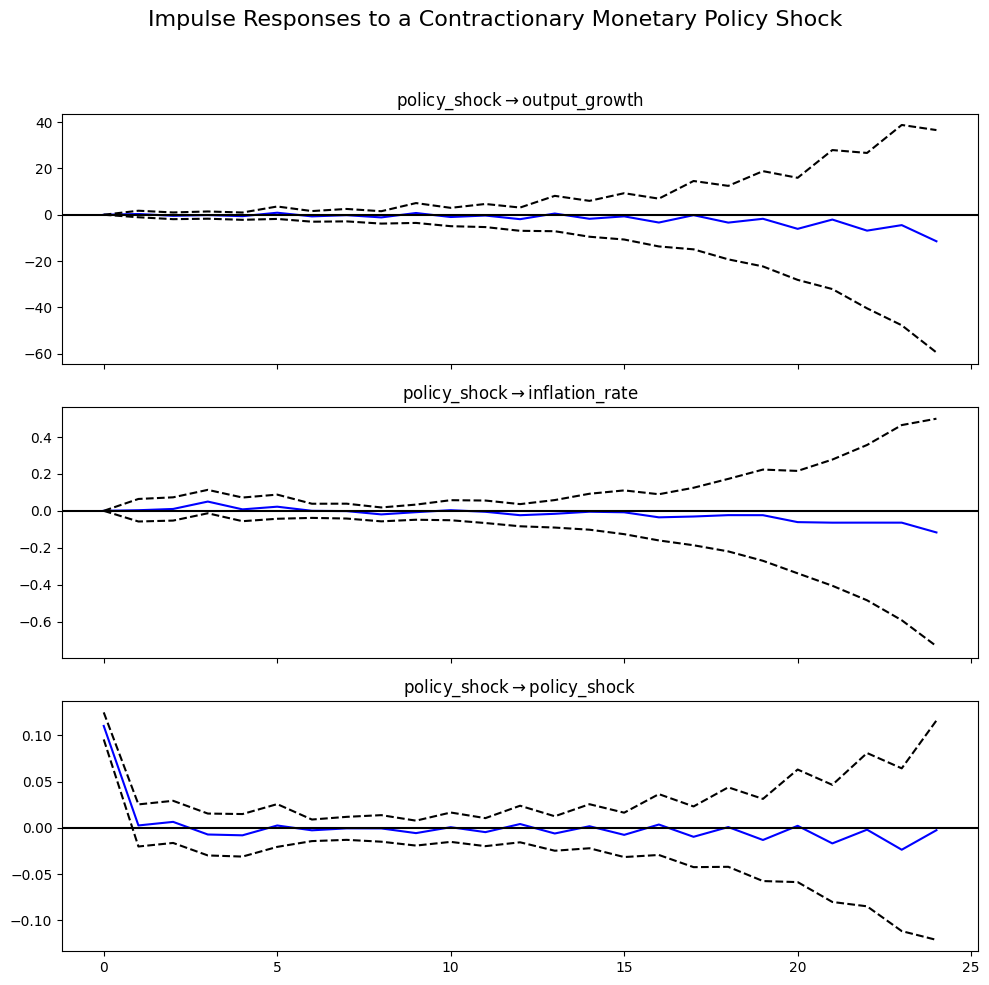

Saved IRF plot to 'irf_monetary_policy_shock.png'.

--- Generating Forecast Error Variance Decomposition (FEVD) plot ---


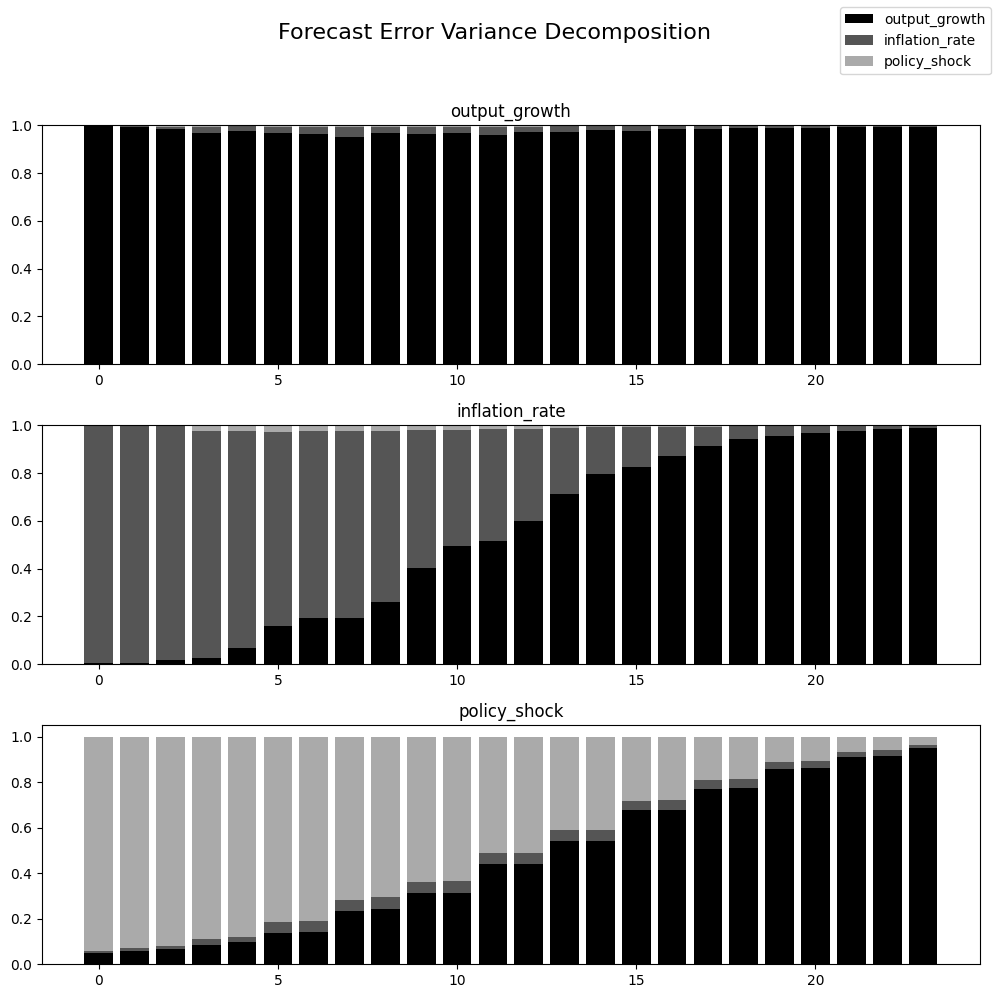

Saved FEVD plot to 'fevd_plot.png'.

-----------------------------------------------------------------------
                          POLICY ANALYSIS & CONCLUSION
-----------------------------------------------------------------------

1. INTERPRETATION OF IMPULSE RESPONSES (IRFs):
   - Examine the 'irf_monetary_policy_shock.png' plot.
   - Response of 'output_growth' to 'policy_shock': A contractionary shock (unexpected rate hike) should theoretically lead to a temporary decrease in output growth. Check if the response is negative and statistically significant (i.e., the confidence interval does not contain zero).
   - Response of 'inflation_rate' to 'policy_shock': The shock should lead to a fall in inflation. This response often occurs with a longer lag than the output response.
   - Note on the 'Price Puzzle': In some studies, inflation briefly increases after a rate hike. If observed, this is a well-known anomaly that can be discussed.

2. INTERPRETATION OF VARIANCE DECOMPOSITION

In [8]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Starting Phase 4: Structural Analysis with SVAR ---")

# Load the fitted VAR model and the data
try:
    model = joblib.load('var_model_fitted.pkl')
    df = pd.read_csv('prepared_svar_data.csv', index_col='Date', parse_dates=True)
    df = df[['output_growth', 'inflation_rate', 'policy_shock']] # Ensure same order
    print("Fitted VAR model and data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please run the previous scripts first.")
    exit()

# Define number of periods for impulse responses
horizon = 24  # 24 months (2 years)

# --- Step 1: Impulse Response Functions (IRFs) ---
# The .irf() method computes the impulse responses.
# The Cholesky decomposition is applied by default in statsmodels.
irf = model.irf(periods=horizon)

# Plot the IRFs of a shock to the 'policy_shock' variable
# This shows how output and inflation respond to a surprise 1 std. dev. increase in the policy rate.
print("\n--- Generating Impulse Response Function (IRF) plots ---")
plot = irf.plot(orth=True, impulse='policy_shock', response=None, signif=0.05)
plot.suptitle('Impulse Responses to a Contractionary Monetary Policy Shock', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('irf_monetary_policy_shock.png')
plt.show()
print("Saved IRF plot to 'irf_monetary_policy_shock.png'.")

# --- Step 2: Forecast Error Variance Decomposition (FEVD) ---
print("\n--- Generating Forecast Error Variance Decomposition (FEVD) plot ---")
fevd = model.fevd(horizon)

# Plot the FEVD
fevd_plot = fevd.plot()
fevd_plot.suptitle('Forecast Error Variance Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('fevd_plot.png')
plt.show()
print("Saved FEVD plot to 'fevd_plot.png'.")


# --- Step 3: Interpretation (Phase 5) ---
print("""
-----------------------------------------------------------------------
                          POLICY ANALYSIS & CONCLUSION
-----------------------------------------------------------------------
""")
print("1. INTERPRETATION OF IMPULSE RESPONSES (IRFs):")
print("   - Examine the 'irf_monetary_policy_shock.png' plot.")
print("   - Response of 'output_growth' to 'policy_shock': A contractionary shock (unexpected rate hike) should theoretically lead to a temporary decrease in output growth. Check if the response is negative and statistically significant (i.e., the confidence interval does not contain zero).")
print("   - Response of 'inflation_rate' to 'policy_shock': The shock should lead to a fall in inflation. This response often occurs with a longer lag than the output response.")
print("   - Note on the 'Price Puzzle': In some studies, inflation briefly increases after a rate hike. If observed, this is a well-known anomaly that can be discussed.")

print("\n2. INTERPRETATION OF VARIANCE DECOMPOSITION (FEVD):")
print("   - Examine the 'fevd_plot.png'.")
print("   - This tells us what proportion of future uncertainty in a variable is due to shocks from other variables.")
print("   - For 'output_growth' and 'inflation_rate', check how much of their forecast error variance is explained by 'policy_shock' over time. This quantifies the importance of monetary policy in driving business cycles and inflation dynamics.")

print("\n3. CONCLUSION FOR RBI'S DEPARTMENT OF ECONOMIC AND POLICY RESEARCH (DEPR):")
print("   This SVAR analysis provides quantitative estimates of the monetary policy transmission mechanism in India. The results suggest the speed and magnitude of the effects of policy rate changes on the real economy and inflation. These findings are critical for calibrating monetary policy actions, managing trade-offs between growth and inflation, and contributing to the RBI's core mission of maintaining price stability.")
print("\n-----------------------------------------------------------------------")

print("\nProject complete.")